EDA questions:

Condo and pool?

How does having a pool affect property values?

Does garage type matter? Is just T/F enough or do we need number of spaces?

Do we want to include buying multi-family? 

Do we want to include the manufactured properties? They seem to be mostly mobile homes, but there are some single family homes mixed in.

drop propertyType apartment, Multi-Family, Manufactured, maybe/probably Land, probably Townhouse
use isin to get just 
data = data[data['propertyType'].isin(['Single Family','Condo'])]

Encoding cities using numbers based on some aggregated price -- might be like artificially weighting since it overlaps completely with location

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score



In [5]:
data1 = pd.read_csv('/workspaces/mds8-final-project-bmh/data/interim/csv_files/rentcast_FL.csv')
data2 = pd.read_csv('/workspaces/mds8-final-project-bmh/data/interim/csv_files/rentcast_FL_2.csv')
data3 = pd.read_csv('/workspaces/mds8-final-project-bmh/data/interim/csv_files/rentcast_FL_3.csv')

data = pd.concat([data1, data2, data3])

data.shape


/tmp/ipykernel_42663/2920854558.py:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  data1 = pd.read_csv('/workspaces/mds8-final-project-bmh/data/interim/csv_files/rentcast_FL.csv')
/tmp/ipykernel_42663/2920854558.py:2: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  data2 = pd.read_csv('/workspaces/mds8-final-project-bmh/data/interim/csv_files/rentcast_FL_2.csv')


(145618, 35)

In [49]:
data.head()

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,exteriorType,fireplace,floorCount,foundationType,garage,pool,unitCount
0,"1960-S-Ocean-Blvd,-Manalapan,-FL-33462","1960 S Ocean Blvd, Manalapan, FL 33462",Manalapan,FL,33462,Palm Beach,26.551645,-80.042184,Single Family,8.0,...,27500000.0,False,False,NaN,False,NaN,NaN,False,False,NaN
2,"1070-Rhonda-Rd,-Jacksonville,-FL-32254","1070 Rhonda Rd, Jacksonville, FL 32254",Jacksonville,FL,32254,Duval,30.339189,-81.717711,Single Family,3.0,...,170000.0,True,True,Stucco,False,1.0,NaN,True,False,1.0
3,"2200-S-Ocean-Dr,-Apt-N108,-Hollywood,-FL-33019","2200 S Ocean Dr, Apt N108, Hollywood, FL 33019",Hollywood,FL,33019,Broward,25.999305,-80.118487,Condo,2.0,...,300000.0,False,False,NaN,False,NaN,NaN,False,False,NaN
4,"6065-Parkwalk-Dr,-Boynton-Beach,-FL-33472","6065 Parkwalk Dr, Boynton Beach, FL 33472",Boynton Beach,FL,33472,Palm Beach,26.556118,-80.137678,Condo,2.0,...,250000.0,False,False,NaN,False,NaN,NaN,False,False,NaN
5,"8734-Carmel-Mountain-Way,-Boynton-Beach,-FL-33473","8734 Carmel Mountain Way, Boynton Beach, FL 33473",Boynton Beach,FL,33473,Palm Beach,26.493040,-80.183199,Single Family,3.0,...,765000.0,True,True,Stucco,False,1.0,NaN,True,True,NaN


In [6]:
data.duplicated().any()

np.True_

In [7]:
data = data.drop_duplicates()
data.shape

(145617, 35)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145617 entries, 0 to 4999
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                145617 non-null  object 
 1   formattedAddress  145617 non-null  object 
 2   city              145617 non-null  object 
 3   state             145617 non-null  object 
 4   zipCode           145617 non-null  int64  
 5   county            145495 non-null  object 
 6   latitude          145617 non-null  float64
 7   longitude         145617 non-null  float64
 8   propertyType      143304 non-null  object 
 9   bedrooms          126303 non-null  float64
 10  bathrooms         127999 non-null  float64
 11  squareFootage     130281 non-null  float64
 12  lotSize           128260 non-null  float64
 13  yearBuilt         127154 non-null  float64
 14  subdivision       117944 non-null  object 
 15  zoning            86564 non-null   object 
 16  lastSaleDate      145617 no

In [9]:
# Dropping columns with few values

drop_cols = ['zoning','hoa','architectureType','coolingType','heatingType','garageSpaces','garageType','roomCount','viewType']

data = data.drop(drop_cols, axis=1)
data.shape

(145617, 26)

In [10]:
data.columns.tolist()

['id',
 'formattedAddress',
 'city',
 'state',
 'zipCode',
 'county',
 'latitude',
 'longitude',
 'propertyType',
 'bedrooms',
 'bathrooms',
 'squareFootage',
 'lotSize',
 'yearBuilt',
 'subdivision',
 'lastSaleDate',
 'lastSalePrice',
 'cooling',
 'heating',
 'exteriorType',
 'fireplace',
 'floorCount',
 'foundationType',
 'garage',
 'pool',
 'unitCount']

# EDA on unitCount

In [11]:
data['unitCount'].describe()

count    96266.000000
mean         1.190493
std         25.374905
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       5760.000000
Name: unitCount, dtype: float64

Massive range of values, but the majority of properties are single unit.

# EDA on propertyType

In [12]:
data['propertyType'].value_counts()

propertyType
Single Family    99845
Condo            22687
Land             12123
Manufactured      3834
Multi-Family      2417
Townhouse         1842
Apartment          556
Name: count, dtype: int64

Most properties are condo or single family.

In [13]:
# Looking at propertyType --> Land

land = data[data['propertyType'] == 'Land']
land.shape

(12123, 26)

In [14]:
land.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,floorCount,unitCount
count,12123.000000,12123.000000,12123.000000,5001.000000,5096.000000,5095.000000,1.142200e+04,4304.000000,1.205900e+04,645.000000,586.000000
mean,33760.805081,27.930937,-81.922392,3.399720,2.423764,1954.713837,2.595635e+04,2013.439591,7.527074e+05,1.113178,1.071672
std,788.946508,1.107680,1.019182,0.917383,0.743719,1820.084495,1.962542e+05,25.416806,3.002084e+06,0.321917,0.518033
min,32009.000000,24.554356,-87.492508,0.000000,1.000000,100.000000,4.000000e+00,1700.000000,5.100000e+02,1.000000,1.000000
25%,33513.000000,27.024100,-82.323048,3.000000,2.000000,1560.000000,5.528000e+03,2023.000000,1.473000e+05,1.000000,1.000000
50%,33928.000000,27.977042,-81.791403,3.000000,2.500000,1828.000000,7.841000e+03,2024.000000,3.700000e+05,1.000000,1.000000
75%,34275.000000,28.503073,-81.489770,4.000000,3.000000,2207.000000,1.089000e+04,2024.000000,5.323000e+05,1.000000,1.000000
max,34997.000000,30.992581,-80.035828,20.000000,17.000000,121992.000000,8.140057e+06,2027.000000,8.500000e+07,3.000000,9.000000


Assuming this property type is empty land on which to build, there are a surprsing number of bedrooms, bathrooms, etc. Rows with this property type may need to be dropped from the model.

In [15]:
# Looking at propertyType --> Manufactured

manufactured = data[data['propertyType'] == 'Manufactured']
manufactured.shape

(3834, 26)

In [16]:
manufactured.describe()

,zipCode,latitude,longitude,bedrooms,bathrooms,squareFootage,lotSize,yearBuilt,lastSalePrice,floorCount,unitCount
count,3834.000000,3834.000000,3834.000000,3395.000000,3585.000000,3803.000000,3.747000e+03,3808.000000,3.834000e+03,2853.000000,3297.000000
mean,33589.934011,28.169024,-81.968781,2.432106,1.796374,1125.888772,3.419714e+04,1986.935137,1.826119e+05,1.002804,2.519867
std,855.974223,1.199170,1.069604,0.723195,0.452964,439.710224,2.012001e+05,14.563097,5.369107e+05,0.052888,87.060970
min,32003.000000,24.566139,-87.510107,1.000000,1.000000,60.000000,1.000000e+00,1900.000000,6.000000e+02,1.000000,1.000000
25%,32907.000000,27.451554,-82.377048,2.000000,2.000000,820.000000,4.755000e+03,1976.000000,9.370000e+04,1.000000,1.000000
50%,33810.000000,28.197868,-81.942557,2.000000,2.000000,1104.000000,7.153000e+03,1985.000000,1.500000e+05,1.000000,1.000000
75%,34228.000000,28.946323,-81.576930,3.000000,2.000000,1380.000000,1.655300e+04,1997.000000,2.100000e+05,1.000000,1.000000
max,34997.000000,30.946223,-80.060530,7.000000,4.000000,8750.000000,5.462023e+06,2025.000000,2.250000e+07,2.000000,5000.000000


In [17]:
# It looks like this is mostly single units, but the max is 5,000 for units

manufactured['unitCount'].value_counts()

unitCount
1.0       3286
2.0          9
5000.0       1
4.0          1
Name: count, dtype: int64

In [18]:
# Looking at the outlier

manufactured[manufactured['unitCount'] == 5000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,exteriorType,fireplace,floorCount,foundationType,garage,pool,unitCount
9089,"20300-Leonard-Rd,-Lot-51,-Lutz,-FL-33558","20300 Leonard Rd, Lot 51, Lutz, FL 33558",Lutz,FL,33558,Pasco,28.185959,-82.480042,Manufactured,NaN,...,245000.0,True,True,Other,False,1.0,NaN,False,False,5000.0


From checking Zillow on this address, this is an entire condo complex--probably outside the scope of the project.

What are the single-unit properties in this category like?

In [19]:
manufactured = manufactured[manufactured['unitCount'] == 1.0]
manufactured.head(25)

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,exteriorType,fireplace,floorCount,foundationType,garage,pool,unitCount
67,"8709-S-Meadowview-Cir,-Tampa,-FL-33625","8709 S Meadowview Cir, Tampa, FL 33625",Tampa,FL,33625,Hillsborough,28.053556,-82.577342,Manufactured,2.0,...,225000.0,True,True,Metal,False,1.0,NaN,True,False,1.0
97,"3141-Old-Farm-House-Dr,-North-Fort-Myers,-FL-3...","3141 Old Farm House Dr, North Fort Myers, FL 3...",North Fort Myers,FL,33917,Lee,26.709915,-81.895790,Manufactured,2.0,...,165000.0,True,True,Aluminum / Vinyl Siding,False,1.0,NaN,True,False,1.0
98,"128-Torch-Ln,-North-Fort-Myers,-FL-33917","128 Torch Ln, North Fort Myers, FL 33917",North Fort Myers,FL,33917,Lee,26.692646,-81.859562,Manufactured,2.0,...,60000.0,True,True,Other,False,1.0,NaN,True,False,1.0
137,"16-Golden-Gate-Cir,-Port-Orange,-FL-32129","16 Golden Gate Cir, Port Orange, FL 32129",Port Orange,FL,32129,Volusia,29.136491,-81.017564,Manufactured,3.0,...,229900.0,True,True,Other,True,1.0,Wood,True,False,1.0
196,"110-Nw-53rd-St,-Deerfield-Beach,-FL-33064","110 Nw 53rd St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.294703,-80.123712,Manufactured,NaN,...,150000.0,False,False,NaN,False,1.0,NaN,False,False,1.0
197,"222-Nw-54th-St,-Deerfield-Beach,-FL-33064","222 Nw 54th St, Deerfield Beach, FL 33064",Deerfield Beach,FL,33064,Broward,26.296940,-80.125560,Manufactured,NaN,...,149000.0,False,False,NaN,False,1.0,NaN,False,False,1.0
296,"1100-Belcher-Rd-S,-Lot-371,-Largo,-FL-33771","1100 Belcher Rd S, Lot 371, Largo, FL 33771",Largo,FL,33771,Pinellas,27.905466,-82.750327,Manufactured,2.0,...,95000.0,True,True,Aluminum / Vinyl Siding,False,1.0,Pier / Post & Beam,True,True,1.0
323,"207-E-Harris-St,-Palatka,-FL-32177","207 E Harris St, Palatka, FL 32177",Palatka,FL,32177,Putnam,29.660439,-81.653605,Manufactured,3.0,...,123000.0,False,False,NaN,False,NaN,NaN,False,False,1.0
471,"220-El-Prado-Pl,-Panama-City-Beach,-FL-32413","220 El Prado Pl, Panama City Beach, FL 32413",Panama City Beach,FL,32413,Bay,30.243290,-85.924014,Manufactured,3.0,...,290000.0,True,True,Wood,False,1.0,NaN,False,False,1.0
477,"457-Citrus-Ridge-Dr,-Davenport,-FL-33837","457 Citrus Ridge Dr, Davenport, FL 33837",Davenport,FL,33837,Polk,28.212509,-81.629595,Manufactured,2.0,...,75000.0,False,False,NaN,False,NaN,NaN,True,False,1.0


Looking at some of these on Zillow, they seem to be mostly mobile homes with a few single family homes mixed in. TBD if we want to include them in the model.

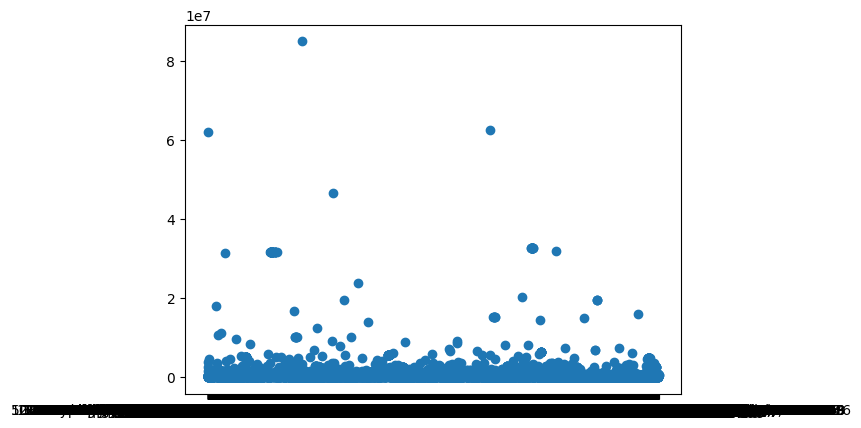

In [20]:
# Range of values for Land

plt.scatter(x=land.id, y=land.lastSalePrice)
plt.show()

In [21]:
# data.lastSaleDate = pd.to_datetime(data.lastSaleDate)

# data['year_month'] = data['lastSaleDate'].dt.to_period('M')

# t_rate = {
#     '2024-03':0.0421,
#     '2024-04':0.0454,
#     '2024-05':0.0448,
#     '2024-06':0.0431,
#     '2024-07':0.0425,
#     '2024-08':0.0387,
#     '2024-09':0.0372,
#     '2024-10':0.0410,
#     '2024-11':0.0436,
#     '2024-12':0.0439,
#     '2025-01':0.0463,
#     '2025-02':0.0445,
#     '2025-03':0.0454
# }

# data['year_month'] = data['year_month'].dt.strftime('%Y-%m')

# data['year_month'].map(t_rate)

# # save as a new column t_rate


In [22]:
data.lastSaleDate.nunique()


300

In [23]:
data.city.unique()

array(['Manalapan', 'Saint Petersburg', 'Jacksonville', 'Hollywood',
       'Boynton Beach', 'Land O Lakes', 'Wellington', 'Tampa',
       'Fort Myers', 'Bradenton', 'Miami', 'Winter Park', 'Orlando',
       'Deerfield Beach', 'Riverview', 'Sarasota', 'West Palm Beach',
       'Port Saint Lucie', 'Palm Coast', 'Fort Lauderdale',
       'North Lauderdale', 'Miami Gardens', 'Temple Terrace',
       'Saint Augustine', 'Fort Myers Beach', 'Lehigh Acres',
       'Panama City', 'Miami Shores', 'Doral', 'Key West', 'Vero Beach',
       'Ocala', 'Daytona Beach', 'Homestead', 'Inverness',
       'Jacksonville Beach', 'Boca Raton', 'Port Charlotte',
       'Delray Beach', 'Indian Harbour Beach', 'New Port Richey',
       'Apollo Beach', 'Palm Beach Gardens', 'Tallahassee', 'Leesburg',
       'Sanford', 'Deltona', 'North Palm Beach', 'North Fort Myers',
       'Palm Bay', 'Palm Harbor', 'Seminole', 'Lady Lake', 'Longboat Key',
       'Tavares', 'Oviedo', 'Elkton', 'Santa Rosa Beach', 'Beverly Hil

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145617 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                145617 non-null  object 
 1   formattedAddress  145617 non-null  object 
 2   city              145617 non-null  object 
 3   state             145617 non-null  object 
 4   zipCode           145617 non-null  int64  
 5   county            145495 non-null  object 
 6   latitude          145617 non-null  float64
 7   longitude         145617 non-null  float64
 8   propertyType      143304 non-null  object 
 9   bedrooms          126303 non-null  float64
 10  bathrooms         127999 non-null  float64
 11  squareFootage     130281 non-null  float64
 12  lotSize           128260 non-null  float64
 13  yearBuilt         127154 non-null  float64
 14  subdivision       117944 non-null  object 
 15  lastSaleDate      145617 non-null  object 
 16  lastSalePrice     145533 no

In [25]:
data.propertyType.value_counts()

propertyType
Single Family    99845
Condo            22687
Land             12123
Manufactured      3834
Multi-Family      2417
Townhouse         1842
Apartment          556
Name: count, dtype: int64

In [26]:
singleFamily = data[data['propertyType'] == 'Single Family']
singleFamily.shape

(99845, 26)

In [27]:
multiFamily = data[data['propertyType'] == 'Multi-Family']
multiFamily.shape

(2417, 26)

# EDA on multiFamily

In [28]:
multiFamily.shape

(2417, 26)

In [29]:
multiFamily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2417 entries, 26 to 4992
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2417 non-null   object 
 1   formattedAddress  2417 non-null   object 
 2   city              2417 non-null   object 
 3   state             2417 non-null   object 
 4   zipCode           2417 non-null   int64  
 5   county            2413 non-null   object 
 6   latitude          2417 non-null   float64
 7   longitude         2417 non-null   float64
 8   propertyType      2417 non-null   object 
 9   bedrooms          2262 non-null   float64
 10  bathrooms         2341 non-null   float64
 11  squareFootage     2358 non-null   float64
 12  lotSize           2331 non-null   float64
 13  yearBuilt         2374 non-null   float64
 14  subdivision       1834 non-null   object 
 15  lastSaleDate      2417 non-null   object 
 16  lastSalePrice     2416 non-null   float64
 17 

In [30]:
# # Looking at range of sale values

# plt.scatter(x=multiFamily.id, y=multiFamily.lastSalePrice)
# plt.show()

In [31]:
# What is the 100000000+ million dollar place? And some of these other outliers over 20,000,000

multiFamily[multiFamily.lastSalePrice > 20000000]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,exteriorType,fireplace,floorCount,foundationType,garage,pool,unitCount
1339,"1809-Jackson-St,-Unit-619,-Hollywood,-FL-33020","1809 Jackson St, Unit 619, Hollywood, FL 33020",Hollywood,FL,33020,Broward,26.008930,-80.143410,Multi-Family,2.0,...,62000000.0,False,False,NaN,False,12.0,NaN,True,False,NaN
15217,"3317-Broadway,-West-Palm-Beach,-FL-33407","3317 Broadway, West Palm Beach, FL 33407",West Palm Beach,FL,33407,Palm Beach,26.743198,-80.056935,Multi-Family,6.0,...,109285714.0,True,True,Stucco,False,2.0,NaN,True,False,NaN
63069,"1345-W-28th-St,-Apt-2,-Hialeah,-FL-33010","1345 W 28th St, Apt 2, Hialeah, FL 33010",Hialeah,FL,33010,Miami-Dade,25.847361,-80.309305,Multi-Family,2.0,...,20610000.0,False,False,NaN,False,NaN,NaN,False,False,NaN
4643,"1495-Spring-Harbor-Dr,-Delray-Beach,-FL-33445","1495 Spring Harbor Dr, Delray Beach, FL 33445",Delray Beach,FL,33445,Palm Beach,26.437936,-80.092683,Multi-Family,1.0,...,111640000.0,False,False,NaN,False,NaN,NaN,False,False,NaN
28827,"7960-Pine-Crossings-Cir,-Orlando,-FL-32807","7960 Pine Crossings Cir, Orlando, FL 32807",Orlando,FL,32807,Orange,28.545065,-81.280277,Multi-Family,2.0,...,50000000.0,True,True,Wood,True,2.0,NaN,True,True,14.0


From Zillow research, these seem to be either large apartment buildings or innacurate records. The multi-family column seems like it might be out of the scope of this project.

In [32]:
# Looking at the 10 to 20 million range

multiFamily[(multiFamily.lastSalePrice < 20000000) & (multiFamily.lastSalePrice > 10000000)]

,id,formattedAddress,city,state,zipCode,county,latitude,longitude,propertyType,bedrooms,...,lastSalePrice,cooling,heating,exteriorType,fireplace,floorCount,foundationType,garage,pool,unitCount
24077,"101-Mosswood-Cir,-Winter-Springs,-FL-32708","101 Mosswood Cir, Winter Springs, FL 32708",Winter Springs,FL,32708,Seminole,28.693565,-81.304557,Multi-Family,NaN,...,10514600.0,False,False,Marblecrete,False,1.0,NaN,False,False,NaN
24768,"140-Mosswood-Cir,-Winter-Springs,-FL-32708","140 Mosswood Cir, Winter Springs, FL 32708",Winter Springs,FL,32708,Seminole,28.692733,-81.303319,Multi-Family,NaN,...,10514600.0,True,True,Marblecrete,False,1.0,NaN,False,False,NaN
74570,"11900-Nw-19th-Ave,-Miami,-FL-33167","11900 Nw 19th Ave, Miami, FL 33167",Miami,FL,33167,Miami-Dade,25.883316,-80.231757,Multi-Family,128.0,...,11000000.0,True,False,Stucco,False,2.0,Footing,True,False,3.0
25951,"243-Ne-12th-Ave,-Homestead,-FL-33030","243 Ne 12th Ave, Homestead, FL 33030",Homestead,FL,33030,Miami-Dade,25.472529,-80.460070,Multi-Family,62.0,...,14750000.0,True,False,Concrete Block / Stucco,False,2.0,NaN,False,False,10.0
33319,"3681-Sw-60th-Ter,-Apt-4,-Davie,-FL-33314","3681 Sw 60th Ter, Apt 4, Davie, FL 33314",Davie,FL,33314,Broward,26.076095,-80.227879,Multi-Family,6.0,...,11000000.0,False,False,NaN,False,2.0,NaN,False,False,4.0
37461,"14555-Ne-6th-Ave,-Unit-106,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 106, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.909416,-80.187037,Multi-Family,1.0,...,12375000.0,False,False,NaN,False,NaN,NaN,False,False,NaN
37465,"14555-Ne-6th-Ave,-Unit-225,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 225, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.909416,-80.187037,Multi-Family,1.0,...,12375000.0,False,False,NaN,False,NaN,NaN,False,False,NaN
37467,"14555-Ne-6th-Ave,-Unit-105,-North-Miami,-FL-33161","14555 Ne 6th Ave, Unit 105, North Miami, FL 33161",North Miami,FL,33161,Miami-Dade,25.909416,-80.187037,Multi-Family,1.0,...,12375000.0,False,False,NaN,False,NaN,NaN,False,False,NaN


In [33]:
# # Dropping some outliers

# multiFamily_under20mil = multiFamily[multiFamily['lastSalePrice'] < 20000000]

# plt.scatter(x=multiFamily_under20mil.id, y=multiFamily_under20mil.lastSalePrice)
# plt.show()

What is a 10 million dollar multi-family home? Is this an entire apartment building? Do we want to include these at all?

In [34]:
# # Looking at range of square footage

# plt.scatter(x=multiFamily.id, y=multiFamily.squareFootage)
# plt.show()

This one seems incorrect--Redfin values it at under a million and 24 beds

In [35]:
# multiFamily = multiFamily[multiFamily['squareFootage'] < 50000]

# plt.scatter(x=multiFamily.id, y=multiFamily.squareFootage)
# plt.show()

In [36]:
# plt.scatter(multiFamily.squareFootage, multiFamily.lastSalePrice)
# plt.show()

In [37]:
data.columns.tolist()

['id',
 'formattedAddress',
 'city',
 'state',
 'zipCode',
 'county',
 'latitude',
 'longitude',
 'propertyType',
 'bedrooms',
 'bathrooms',
 'squareFootage',
 'lotSize',
 'yearBuilt',
 'subdivision',
 'lastSaleDate',
 'lastSalePrice',
 'cooling',
 'heating',
 'exteriorType',
 'fireplace',
 'floorCount',
 'foundationType',
 'garage',
 'pool',
 'unitCount']

In [38]:
# EDA on yearBuilt

years = data['yearBuilt']

years.value_counts(normalize=True)


yearBuilt
2024.0    0.063930
2023.0    0.036004
2006.0    0.025945
2005.0    0.024128
2004.0    0.019174
            ...   
202.0     0.000008
1895.0    0.000008
1898.0    0.000008
1865.0    0.000008
2027.0    0.000008
Name: proportion, Length: 148, dtype: float64

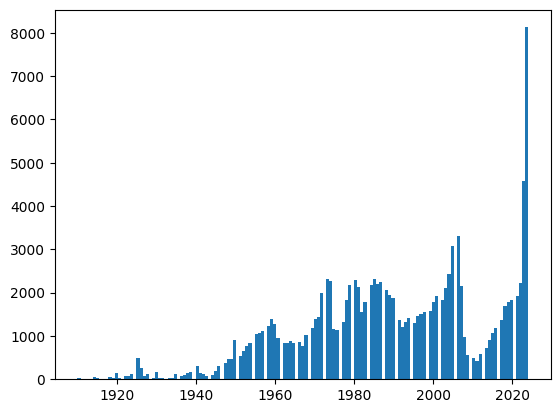

In [39]:
plt.hist(data['yearBuilt'], bins=145, range=(1910,2024))
plt.show()

In [40]:
# data = data[(data['propertyType'] == 'Single Family') | (data['propertyType'] == 'Condo')]

# year_eda_cols = ['zipCode','bedrooms','bathrooms','squareFootage','lotSize','lastSalePrice']

# year_eda = data[year_eda_cols]

# sns.pairplot(year_eda)
# plt.show()

# Moving towards modeling

In [41]:
data.city.value_counts().head(10)

city
Jacksonville        5997
Miami               4842
Orlando             4248
Tampa               4023
Naples              3132
Cape Coral          2784
Kissimmee           2691
Ocala               2614
Saint Petersburg    2598
Bradenton           2409
Name: count, dtype: int64

In [42]:
data = data[(data['propertyType'] == 'Single Family') | (data['propertyType'] == 'Condo')]
data.shape

(122532, 26)

In [43]:
city_counts = data.city.value_counts()
big_cities = city_counts[city_counts >= 1966].index

filtered_by_city = data[data.city.isin(big_cities)]

filtered_by_city.shape

(31006, 26)

In [44]:
test_cols = ['zipCode','latitude','longitude','bedrooms','bathrooms','squareFootage','lotSize','lastSalePrice']

filtered_by_city = filtered_by_city[test_cols]
filtered_by_city = filtered_by_city.dropna()
filtered_by_city.shape

(26684, 8)

In [45]:
# Features and target, splitting data, scaling

y = filtered_by_city['lastSalePrice']
X = filtered_by_city.drop(['lastSalePrice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
# Linear Regression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 1763230243576.5037
Coefficient of determination: 0.2440027276375859


In [47]:
# Random Forest Regressor

regressor = RandomForestRegressor()
regressor.fit(X_train_scaled, y_train)

y_pred = regressor.predict(X_test_scaled)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")

Mean squared error: 1801850023400.494
Coefficient of determination: 0.22744422751399906


In [48]:
X_train_scaled.shape

(21347, 7)